In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Importazione ed esplorazione dei dati

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/AML_Project/weatherAUS.csv')
#data.head()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


Variabile target sbilanciata

In [ ]:
data['RainTomorrow'].value_counts()/len(data)

No     0.758394
Yes    0.219146
Name: RainTomorrow, dtype: float64

Si nota che vi è una forte presenza di missing values, tale problematica deve essere affrontata come priorità.

In [ ]:
data.isnull().sum() / data.shape[0]

Date             0.000000
Location         0.000000
MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

### Esplorazione grafica

<Figure size 432x432 with 0 Axes>

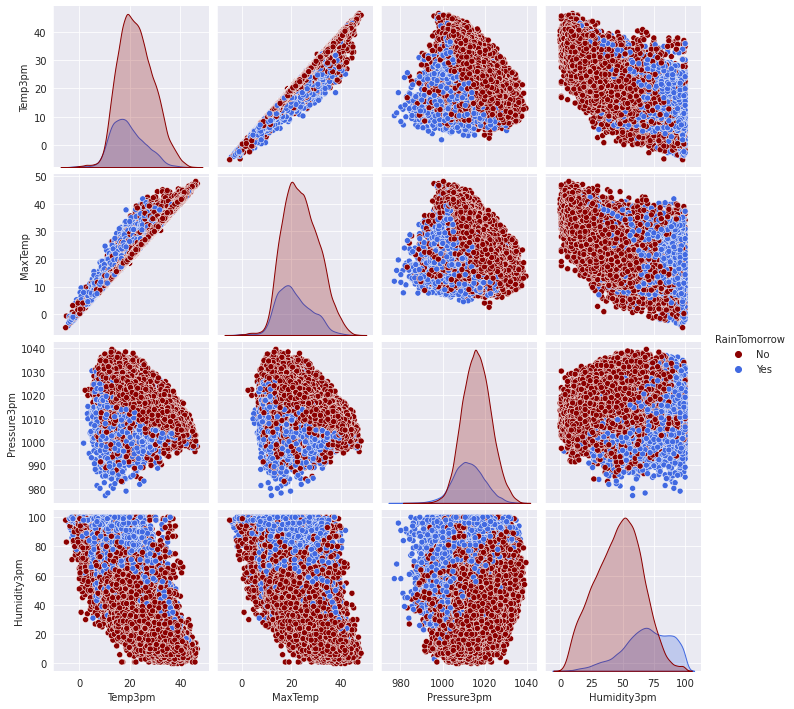

In [ ]:
plt.figure(figsize=(6,6))
sns.pairplot(data[['Temp3pm', 'MaxTemp', 'Pressure3pm', 'Humidity3pm','RainTomorrow']], hue='RainTomorrow', palette=['darkred', 'royalblue'])

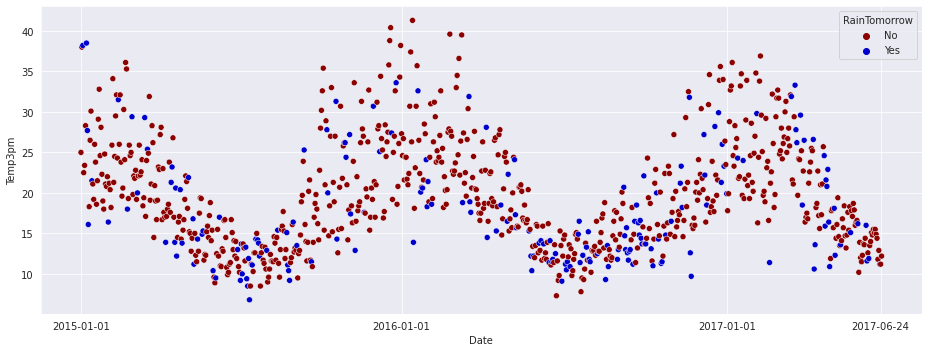

In [ ]:
def plot_TimeSeries(variable='Temp3pm'):
  df_location = data[data['Location']=='MelbourneAirport'].dropna().copy()
  df_location.reset_index(drop=True, inplace=True)
  ts = df_location[(df_location.index > 2048)]
  plt.figure(figsize=(13,5))
  sns.scatterplot(data=ts, x='Date', y=variable, hue='RainTomorrow', palette=['darkred', 'mediumblue'])
  tick_labels = tuple(ts['Date'])
  plt.xticks([tick_labels[index] for index in [0,352,709, 878]]) 
  plt.tight_layout()

plot_TimeSeries()

In [ ]:
numeric=['MinTemp',	'MaxTemp',	'Rainfall',	'Evaporation',	'Sunshine', 'WindGustSpeed',
         	'WindSpeed9am',	'WindSpeed3pm',	'Humidity9am',	'Humidity3pm',	'Pressure9am'	,
         'Pressure3pm', 'Cloud9am',	'Cloud3pm',	'Temp9am'	,'Temp3pm']
categ=['Location', 'WindGustDir', 'WindDir9am',	'WindDir3pm', 'RainToday']

Standardizzazione momentanea delle variabile numeriche per la realizzazione dei boxplot con rimozione delle righe presentanti missing per le variabili RainTomorrow e RainToday

In [ ]:
scaler = StandardScaler()
plt_data = data.dropna(subset=['RainTomorrow', 'RainToday'])
scaler.fit(plt_data[numeric])
std_data = pd.DataFrame(scaler.transform(plt_data[numeric]), columns=plt_data[numeric].columns, index = plt_data.index)

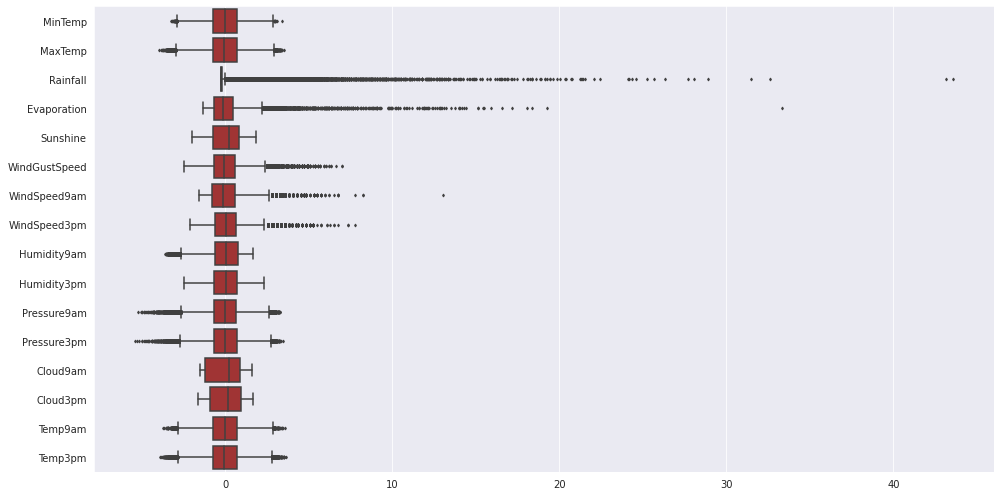

In [ ]:
plt.figure(figsize=(14,7))
sns.boxplot(data=std_data, color='firebrick', fliersize=2, orient='h')
plt.tight_layout()

Text(0, 0.5, 'Evaporation (mm)')

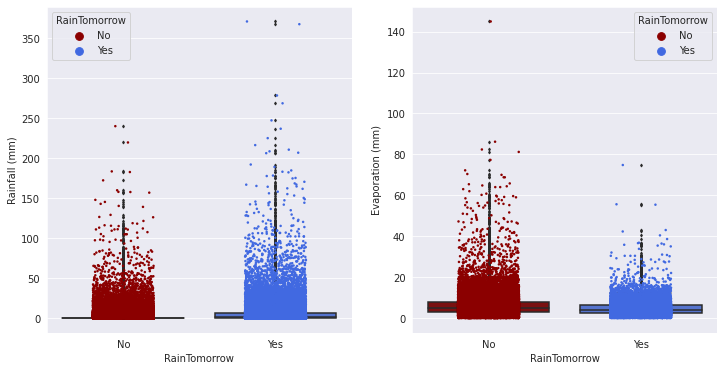

In [ ]:
plt.rcParams['figure.figsize'] = 12, 6
fig, axs = plt.subplots(1,2)
sns.boxplot(data = plt_data , x='RainTomorrow', y='Rainfall', fliersize=2, palette=['darkred', 'royalblue'], ax=axs[0])
sns.stripplot(data=plt_data, x='RainTomorrow', y='Rainfall', hue='RainTomorrow', jitter=0.2, size=2.5,  palette=['darkred', 'royalblue'],ax=axs[0])
axs[0].set_ylabel('Rainfall (mm)')
sns.boxplot(data = plt_data , x='RainTomorrow', y='Evaporation', fliersize=2, palette=['darkred', 'royalblue'],ax=axs[1])
sns.stripplot(data=plt_data, x='RainTomorrow', y='Evaporation', hue='RainTomorrow', jitter=0.2, size=2.5,  palette=['darkred', 'royalblue'],ax=axs[1])
axs[1].set_ylabel('Evaporation (mm)')

Tabella di contingenza

In [ ]:
pd.crosstab(data['RainToday'], data['RainTomorrow'] )

RainTomorrow,No,Yes
RainToday,,
No,92728,16604
Yes,16858,14597


Calcolo delle probabilità condizionate per location.


In [ ]:
probY_Y = pd.DataFrame(columns=['Location', 'Value'])
probY_N = pd.DataFrame(columns=['Location', 'Value'])
for location in plt_data['Location'].unique():
  pp = plt_data[plt_data['Location']==location]
  cross_tab = pd.crosstab(pp['RainToday'], pp['RainTomorrow'])
  value1 = cross_tab.iloc[0,1] / ( cross_tab.iloc[0,1] + cross_tab.iloc[0,0])
  value2 = cross_tab.iloc[1,1] / ( cross_tab.iloc[1,1] + cross_tab.iloc[1,0])
  probY_N = pd.concat( [probY_N, pd.DataFrame( data = {'Location': location, 'Value': value1}, index=[0] )])
  probY_Y = pd.concat( [probY_Y, pd.DataFrame( data = {'Location': location, 'Value': value2}, index=[0] )])

Probabilità che domani piova dato che oggi non piove

Text(0.5, 0, 'Probabilità che piova domani dato che oggi non piove')

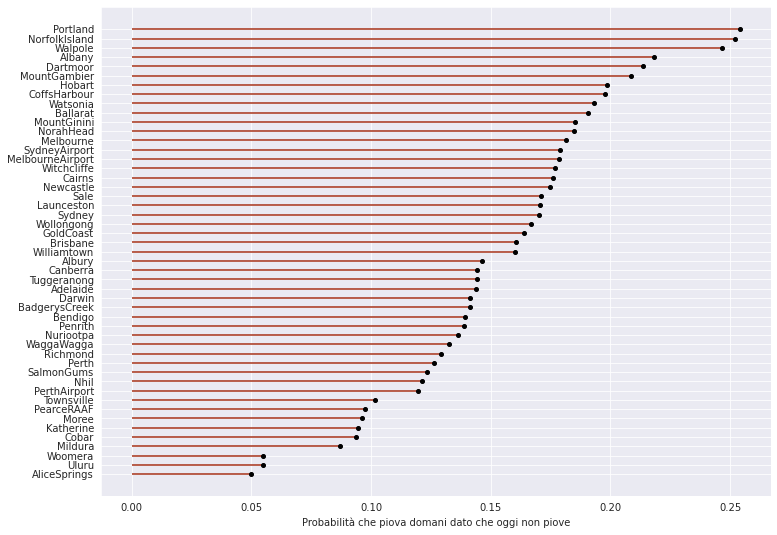

In [ ]:
plt.figure(figsize=(12,9))
plt.hlines(y=probY_N.sort_values('Value', ascending=True)['Location'], xmin=0, xmax=probY_N.sort_values('Value', ascending=True)['Value'], color='#A52F15')
plt.plot(probY_N.sort_values('Value', ascending=True)['Value'], range(0,len(probY_N.index)), "o",color='black', markersize=4)
plt.yticks(range(0,len(probY_N.index)), probY_N.sort_values('Value', ascending=True)['Location'])
plt.xlabel('Probabilità che piova domani dato che oggi non piove')
#plt.tight_layout()

Probabilità che domani piova dato che oggi piove

Text(0.5, 0, 'Probabilità che piova domani dato che oggi piove')

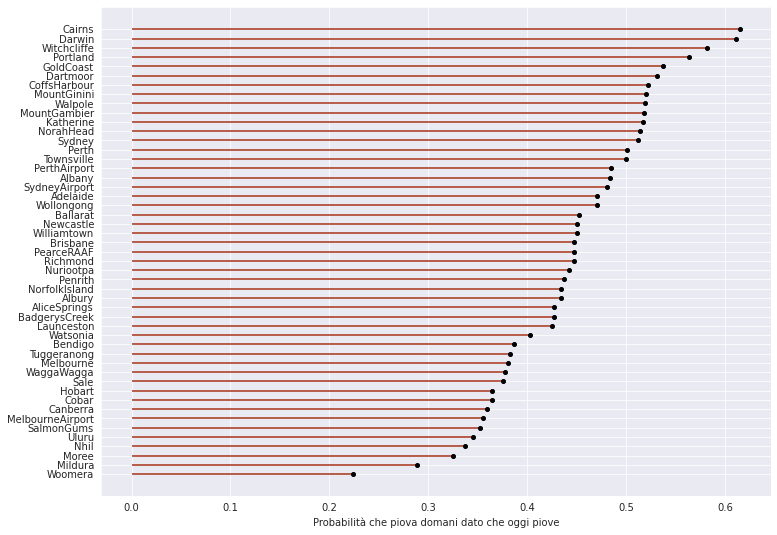

In [ ]:
plt.figure(figsize=(12,9))
plt.hlines(y=probY_Y.sort_values('Value', ascending=True)['Location'], xmin=0, xmax=probY_Y.sort_values('Value', ascending=True)['Value'], color='#A52F15')
plt.plot(probY_Y.sort_values('Value', ascending=True)['Value'], range(0,len(probY_Y.index)), "o",color='black', markersize=4)
plt.yticks(range(0,len(probY_Y.index)), probY_Y.sort_values('Value', ascending=True)['Location'])
plt.xlabel('Probabilità che piova domani dato che oggi piove')
#plt.tight_layout()

## Trattazione Missing Values

Percentuale celle con valore mancante

In [ ]:
nrow=data.shape[0]
ncol=data.shape[1]
element=ncol*nrow
(data.isnull().sum().sum()/element)*100

10.259745694319072

Rimozione di tutte le osservazioni aventi rain today e rain tomorrow mancanti

In [ ]:
data.dropna(subset=['RainTomorrow','RainToday'], inplace=True)
data.reset_index(inplace=True, drop=True)

Selezione città aventi almeno una tra le colonne evaporation, sunshine, cloud3pm e cloud9pm mancante al 100%

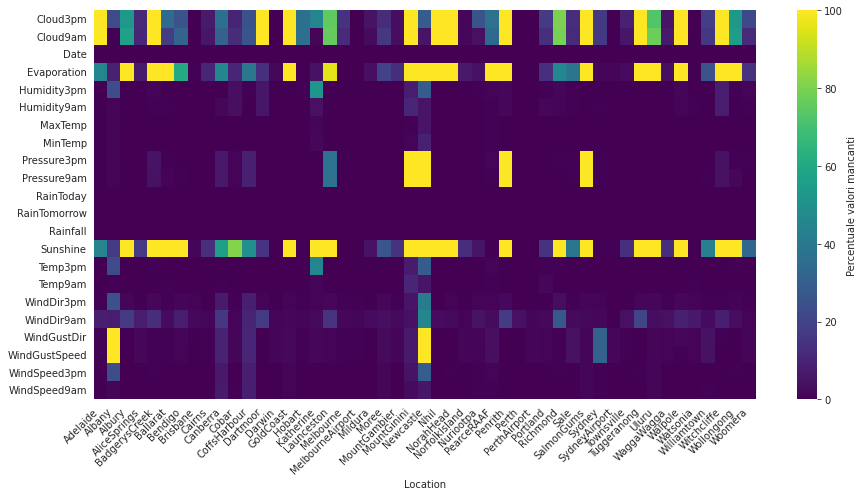

In [ ]:
na_loc = data[data.columns.difference(['Location'])].isnull().groupby(data['Location']).sum().astype(int)#[['Evaporation', 'Sunshine', 'Cloud3pm', 'Cloud9am']]
na_loc = na_loc.apply(lambda x: x/data.groupby('Location').size())

plt.figure(figsize=(13,7))
sns.heatmap(na_loc.T*100, cmap='viridis',  cbar_kws={'label': 'Percentuale valori mancanti'})
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [ ]:
col = ['Evaporation',	'Sunshine',	'Cloud3pm',	'Cloud9am']

city = []
for i in na_loc.index:
  for c in col:
    if na_loc.loc[i,c] == 1.0:
        city.append(i)
city=pd.unique(city)
len(city)

22

Alle città così selezionate sono state rimosse Badgerys Creek e Newcastle perchè tra le città rimanenti sono presenti location affini. Queste verranno quindi incoprorate in seguito

In [ ]:
city = ['Adelaide', 'Albury',  'Ballarat', 'Bendigo',
       'Dartmoor', 'GoldCoast', 'Katherine', 'Launceston', 'MountGinini',
        'Nhil', 'NorahHead', 'PearceRAAF', 'Penrith',
       'Richmond', 'SalmonGums', 'Tuggeranong',  'Uluru', 'Walpole',
       'Witchcliffe', 'Wollongong']

In [ ]:
data = data[~data['Location'].isin(city)]
data.reset_index(inplace=True, drop=True)

In [ ]:
data.isna().sum()

Date                 0
Location             0
MinTemp            358
MaxTemp            223
Rainfall             0
Evaporation      13985
Sunshine         19340
WindGustDir       8499
WindGustSpeed     8476
WindDir9am        4615
WindDir3pm        2860
WindSpeed9am       829
WindSpeed3pm      2181
Humidity9am        559
Humidity3pm       1852
Pressure9am       3692
Pressure3pm       3702
Cloud9am         10426
Cloud3pm         13093
Temp9am            280
Temp3pm           1607
RainToday            0
RainTomorrow         0
dtype: int64

Conteggio righe per quantità di missing

In [ ]:
pd.DataFrame(data.isnull().sum(axis=1), columns=['MissCount']).groupby('MissCount').size()

MissCount
0     56420
1      7756
2      9426
3      2855
4      4854
5       649
6      1340
7      1039
8       496
9       273
10       52
11      590
12      593
13       67
14       20
15        5
16        1
17       55
18       39
dtype: int64

Si rimuovono le righe con almeno 10 missing

In [ ]:
data = data[data.isnull().sum(axis=1)<10]
data.isna().sum().sum()/(85108*23)*100

4.065014069080513

Accorpamento città simili tra cui le prima citate BadgerysCreek e Newcastle

In [ ]:
data['Location']=np.where(data['Location'] == 'BadgerysCreek', 'Sydney', data['Location'])
data['Location']=np.where(data['Location'] == 'SydneyAirport', 'Sydney', data['Location'])
data['Location']=np.where(data['Location'] == 'Williamtown', 'Newcastle', data['Location'])
data['Location']=np.where(data['Location'] == 'MelbourneAirport', 'Melbourne', data['Location'])
data['Location']=np.where(data['Location'] == 'Watsonia', 'Melbourne', data['Location'])
data['Location']=np.where(data['Location'] == 'PerthAirport', 'Perth', data['Location'])

In [ ]:
print(data['Location'].unique())

['Sydney' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle' 'NorfolkIsland'
 'WaggaWagga' 'Canberra' 'Sale' 'Melbourne' 'Mildura' 'Portland'
 'Brisbane' 'Cairns' 'Townsville' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Perth' 'Hobart' 'AliceSprings' 'Darwin']


### Rimozione righe categoriche NaN

A causa della problematicità relativa all'imputazione delle categoriche con un criterio diverso dalla moda, e alla luce del numero ridotto di righe che presentano missing a 'WindGustDir', 'WindDir9am' e	'WindDir3pm', procediamo con la rimozione di queste ultime.

In [ ]:
data.dropna(subset = ['WindGustDir', 'WindDir9am',	'WindDir3pm'], inplace=True)
data.reset_index(inplace=True, drop=True)

### Train - Val - Test split

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split (data.drop("RainTomorrow", axis=1), data["RainTomorrow"], random_state=42, test_size=0.1, stratify=data["RainTomorrow"])

In [ ]:
xtrain, xval, ytrain, yval = train_test_split (xtrain, ytrain, random_state=42, test_size=0.1, stratify=ytrain)

In [ ]:
print(xtrain.shape, xval.shape, xtest.shape)

(61011, 22) (6780, 22) (7533, 22)


In [ ]:
xtrain.isnull().sum()

Date                 0
Location             0
MinTemp             24
MaxTemp             11
Rainfall             0
Evaporation       7723
Sunshine         11556
WindGustDir          0
WindGustSpeed        0
WindDir9am           0
WindDir3pm           0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am        249
Humidity3pm        215
Pressure9am        161
Pressure3pm        142
Cloud9am          7206
Cloud3pm          8184
Temp9am             59
Temp3pm             25
RainToday            0
dtype: int64

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 <a list of 16 Text major ticklabel objects>)

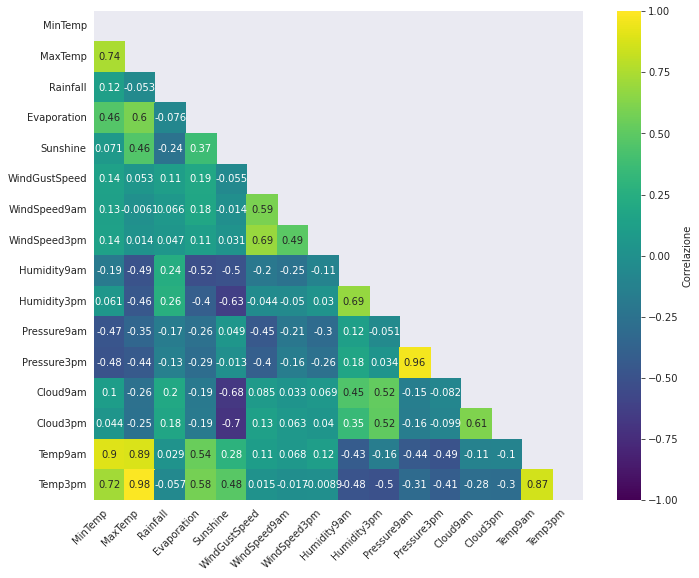

In [ ]:
corrMatrix = xtrain[numeric].corr()
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,9))

sns.heatmap(corrMatrix, mask=mask, square=True, annot=True, vmax=1, vmin=-1, cmap='viridis',cbar_kws={'label': 'Correlazione'})
plt.xticks(rotation=45, ha='right')

### Scelta regressore

Lo scopo è stabilire quale regressore sia il migliore utilizzando un dato di prova che inizialmente non contiene valori missing. Successivamente vengono aggiunti artificialmente dei valori mancanti e si valuta quanto sia elevato l'errore di imputazione rispetto alla ground truth.

In [ ]:
#creo il dataset di prova
xtrain_benchmark = xtrain.copy()

In [ ]:
xtrain_benchmark.dropna(inplace=True)

In [ ]:
xtrain_benchmark.groupby('Location').size().sort_values()

Location
Cobar             432
Canberra          870
Newcastle         965
CoffsHarbour     1110
Sale             1342
Woomera          1411
Moree            1522
Portland         1528
Hobart           1585
Nuriootpa        1625
AliceSprings     1775
Cairns           1958
Townsville       1977
WaggaWagga       1986
MountGambier     2024
NorfolkIsland    2031
Mildura          2094
Brisbane         2403
Darwin           2495
Sydney           3664
Perth            4855
Melbourne        6055
dtype: int64

In [ ]:
#scelgo una singola città per l'imputazione
xtrain_benchmark = xtrain_benchmark[xtrain_benchmark['Location']=='Melbourne'].loc[:,numeric]
xtrain_benchmark = xtrain_benchmark.to_numpy()

In [ ]:
#genero randomicamente dei valori NaN all'interno del dato di prova
n_samples, n_features = xtrain_benchmark.shape
rng = np.random.RandomState(0)
X_missing = xtrain_benchmark.copy()

missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

In [ ]:
#primo regressore da testare in IterativeImputer: ExtraTrees
it_extrees = IterativeImputer(estimator=ExtraTreesRegressor(), initial_strategy='median', max_iter=5, verbose=2, random_state=42)

In [ ]:
xtrain_extrees = it_extrees.fit_transform(X_missing)

[IterativeImputer] Completing matrix with shape (6055, 16)
[IterativeImputer] Ending imputation round 1/5, elapsed time 34.94
[IterativeImputer] Change: 55.620000000000005, scaled tolerance: 1.0393 
[IterativeImputer] Ending imputation round 2/5, elapsed time 77.88
[IterativeImputer] Change: 9.04, scaled tolerance: 1.0393 
[IterativeImputer] Ending imputation round 3/5, elapsed time 113.12
[IterativeImputer] Change: 6.039999999999992, scaled tolerance: 1.0393 
[IterativeImputer] Ending imputation round 4/5, elapsed time 147.86
[IterativeImputer] Change: 5.990000000000009, scaled tolerance: 1.0393 
[IterativeImputer] Ending imputation round 5/5, elapsed time 182.70
[IterativeImputer] Change: 5.359999999999999, scaled tolerance: 1.0393 


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [ ]:
#secondo regressore da testare in IterativeImputer: BayesianRidge
it_bayridge = IterativeImputer(estimator=BayesianRidge(), initial_strategy='median', max_iter=5, verbose=2, random_state=42)

In [ ]:
xtrain_bayridge = it_bayridge.fit_transform(X_missing)

[IterativeImputer] Completing matrix with shape (6055, 16)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.21
[IterativeImputer] Change: 67.46286615981649, scaled tolerance: 1.0393 
[IterativeImputer] Ending imputation round 2/5, elapsed time 0.40
[IterativeImputer] Change: 13.536287850944078, scaled tolerance: 1.0393 
[IterativeImputer] Ending imputation round 3/5, elapsed time 0.57
[IterativeImputer] Change: 1.8454491395522297, scaled tolerance: 1.0393 
[IterativeImputer] Ending imputation round 4/5, elapsed time 0.73
[IterativeImputer] Change: 0.1410757959837099, scaled tolerance: 1.0393 
[IterativeImputer] Early stopping criterion reached.


In [ ]:
#per valutare l'errore di imputazione, per singolo attributo numerico, utilizzo MSE
mse_trees = []
mse_bayridge = []
value_range = []

for i in range(xtrain_benchmark.shape[1]):
  mse_trees.append(mean_squared_error(xtrain_benchmark[:,i], xtrain_extrees[:,i]))
  mse_bayridge.append(mean_squared_error(xtrain_benchmark[:,i], xtrain_bayridge[:,i]))
  value_range.append(xtrain_benchmark[:,i].max()-xtrain_benchmark[:,i].min())

In [ ]:
results_df = pd.DataFrame(mse_trees, columns=['mse_trees'])
results_df['mse_bayridge'] = mse_bayridge
results_df['value_range'] = value_range
results_df['percentage_trees'] = results_df['mse_trees']*100/results_df['value_range']
results_df['percentage_bayridge'] = results_df['mse_bayridge']*100/results_df['value_range']
results_df['diffs'] = results_df['percentage_trees']-results_df['percentage_bayridge']

In [ ]:
# Melbourne
results_df.sort_values(by='diffs')

,mse_trees,mse_bayridge,value_range,percentage_trees,percentage_bayridge,diffs
12,0.126976,0.228588,8.0,1.587194,2.857348,-1.270154
5,3.446043,4.668721,113.0,3.049596,4.131611,-1.082016
6,2.091956,2.776717,65.0,3.218395,4.271873,-1.053478
13,0.104670,0.179249,8.0,1.308378,2.240618,-0.932239
4,0.148343,0.264793,13.9,1.067215,1.904983,-0.837768
9,3.089982,3.801924,94.0,3.287215,4.044600,-0.757384
7,1.756544,2.257276,74.0,2.373707,3.050373,-0.676666
8,4.045518,4.475309,89.0,4.545526,5.028437,-0.482911
2,0.411209,0.745356,84.0,0.489535,0.887328,-0.397794
3,0.235422,0.306414,23.8,0.989169,1.287455,-0.298287


ExraTreesRegressor presenta delle percentuali di errore inferiori.

### Iterative imputer

In [ ]:
data['Location'].unique()

array(['Sydney', 'Cobar', 'CoffsHarbour', 'Moree', 'NorfolkIsland',
       'WaggaWagga', 'Newcastle', 'Canberra', 'Sale', 'Melbourne',
       'Mildura', 'Portland', 'Brisbane', 'Cairns', 'Townsville',
       'MountGambier', 'Nuriootpa', 'Woomera', 'Perth', 'Hobart',
       'AliceSprings', 'Darwin'], dtype=object)

In [ ]:
xtrain.sort_values(by='Location')['Location'].unique()

array(['AliceSprings', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
       'CoffsHarbour', 'Darwin', 'Hobart', 'Melbourne', 'Mildura',
       'Moree', 'MountGambier', 'Newcastle', 'NorfolkIsland', 'Nuriootpa',
       'Perth', 'Portland', 'Sale', 'Sydney', 'Townsville', 'WaggaWagga',
       'Woomera'], dtype=object)

In [ ]:
#ordino i dati alfabeticamente per location
xtrain.sort_values(by='Location', inplace=True)
xval.sort_values(by='Location', inplace=True)
xtest.sort_values(by='Location', inplace=True)

locations = xtrain['Location'].unique()

#inizializzo
xtrain_num_imputed = np.empty((0,len(numeric)))
xval_num_imputed = np.empty((0,len(numeric)))
xtest_num_imputed = np.empty((0,len(numeric)))

for location in locations:
  print(location)
  #imputazione dei valori numerici mancanti sulla location selezionata
  imp_median = IterativeImputer(estimator=ExtraTreesRegressor(), initial_strategy='median', max_iter=5, verbose=1, random_state=42)

  location_train_subset = xtrain[xtrain['Location']==location].loc[:,numeric]
  location_val_subset = xval[xval['Location']==location].loc[:,numeric]
  location_test_subset = xtest[xtest['Location']==location].loc[:,numeric]

  loc_train_imputed = imp_median.fit_transform(location_train_subset)
  loc_val_imputed = imp_median.transform(location_val_subset)
  loc_test_imputed = imp_median.transform(location_test_subset)

  #concateno la matrice inizializzata con la location selezionata
  xtrain_num_imputed = np.concatenate((xtrain_num_imputed,loc_train_imputed), axis=0)
  xval_num_imputed = np.concatenate((xval_num_imputed,loc_val_imputed), axis=0)
  xtest_num_imputed = np.concatenate((xtest_num_imputed,loc_test_imputed), axis=0)

#ricreo i tre dataset di training, validation e set con i dati imputati
xtrain_full = pd.DataFrame(xtrain_num_imputed, columns=numeric)
xval_full = pd.DataFrame(xval_num_imputed, columns=numeric)
xtest_full = pd.DataFrame(xtest_num_imputed, columns=numeric)

#aggiungo le variabili categoriche
xtrain_full[['Date', 'Location', 'WindGustDir', 'WindDir9am',	'WindDir3pm', 'RainToday', 'RainTomorrow']] = xtrain.loc[:,['Date', 'Location', 'WindGustDir', 'WindDir9am',	'WindDir3pm', 'RainToday']].join(ytrain).reset_index(drop=True)
xval_full[['Date', 'Location', 'WindGustDir', 'WindDir9am',	'WindDir3pm', 'RainToday', 'RainTomorrow']] = xval.loc[:,['Date', 'Location', 'WindGustDir', 'WindDir9am',	'WindDir3pm', 'RainToday']].join(yval).reset_index(drop=True)
xtest_full[['Date', 'Location', 'WindGustDir', 'WindDir9am',	'WindDir3pm', 'RainToday', 'RainTomorrow']] = xtest.loc[:,['Date', 'Location', 'WindGustDir', 'WindDir9am',	'WindDir3pm', 'RainToday']].join(ytest).reset_index(drop=True)

xtrain_full_shuffled = xtrain_full.sample(frac=1).reset_index(drop=True)
xval_full_shuffled = xval_full.sample(frac=1).reset_index(drop=True)
xtest_full_shuffled = xtest_full.sample(frac=1).reset_index(drop=True)

AliceSprings
[IterativeImputer] Completing matrix with shape (2202, 16)
[IterativeImputer] Change: 24.979999999999997, scaled tolerance: 1.0325 
[IterativeImputer] Change: 6.946999999999997, scaled tolerance: 1.0325 
[IterativeImputer] Change: 5.153, scaled tolerance: 1.0325 
[IterativeImputer] Change: 3.411999999999997, scaled tolerance: 1.0325 
[IterativeImputer] Change: 6.580000000000002, scaled tolerance: 1.0325 
[IterativeImputer] Completing matrix with shape (261, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (285, 16)
Brisbane
[IterativeImputer] Completing matrix with shape (2468, 16)
[IterativeImputer] Change: 24.048999999999992, scaled tolerance: 1.0339 
[IterativeImputer] Change: 10.45000000000002, scaled tolerance: 1.0339 
[IterativeImputer] Change: 3.578000000000028, scaled tolerance: 1.0339 
[IterativeImputer] Change: 1.3270000000000017, scaled tolerance: 1.0339 
[IterativeImputer] Change: 1.904, scaled tolerance: 1.0339 
[IterativeImputer] Completing matrix with shape (282, 16)
[IterativeImputer] Completing matrix with shape (279, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


Cairns
[IterativeImputer] Completing matrix with shape (2328, 16)
[IterativeImputer] Change: 18.44100000000001, scaled tolerance: 1.0242 
[IterativeImputer] Change: 7.922000000000008, scaled tolerance: 1.0242 
[IterativeImputer] Change: 4.021999999999997, scaled tolerance: 1.0242 
[IterativeImputer] Change: 3.8360000000000016, scaled tolerance: 1.0242 
[IterativeImputer] Change: 3.4709999999999943, scaled tolerance: 1.0242 
[IterativeImputer] Completing matrix with shape (264, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (308, 16)
Canberra
[IterativeImputer] Completing matrix with shape (2208, 16)
[IterativeImputer] Change: 33.846000000000004, scaled tolerance: 1.0402 
[IterativeImputer] Change: 10.620000000000012, scaled tolerance: 1.0402 
[IterativeImputer] Change: 5.2070000000000025, scaled tolerance: 1.0402 
[IterativeImputer] Change: 5.0, scaled tolerance: 1.0402 
[IterativeImputer] Change: 7.332000000000006, scaled tolerance: 1.0402 
[IterativeImputer] Completing matrix with shape (254, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (300, 16)
Cobar
[IterativeImputer] Completing matrix with shape (2384, 16)
[IterativeImputer] Change: 58.748999999999995, scaled tolerance: 1.0366 
[IterativeImputer] Change: 36.223, scaled tolerance: 1.0366 
[IterativeImputer] Change: 13.633000000000003, scaled tolerance: 1.0366 
[IterativeImputer] Change: 13.454000000000008, scaled tolerance: 1.0366 
[IterativeImputer] Change: 10.181999999999995, scaled tolerance: 1.0366 
[IterativeImputer] Completing matrix with shape (256, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (285, 16)
CoffsHarbour
[IterativeImputer] Completing matrix with shape (2074, 16)
[IterativeImputer] Change: 27.995000000000008, scaled tolerance: 1.0368 
[IterativeImputer] Change: 5.207999999999986, scaled tolerance: 1.0368 
[IterativeImputer] Change: 4.118000000000003, scaled tolerance: 1.0368 
[IterativeImputer] Change: 3.526999999999987, scaled tolerance: 1.0368 
[IterativeImputer] Change: 3.620999999999996, scaled tolerance: 1.0368 
[IterativeImputer] Completing matrix with shape (225, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (269, 16)
Darwin
[IterativeImputer] Completing matrix with shape (2538, 16)
[IterativeImputer] Change: 34.72, scaled tolerance: 1.0192999999999999 
[IterativeImputer] Change: 1.7299999999999969, scaled tolerance: 1.0192999999999999 
[IterativeImputer] Change: 1.1400000000000006, scaled tolerance: 1.0192999999999999 
[IterativeImputer] Change: 0.714000000000004, scaled tolerance: 1.0192999999999999 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (283, 16)
[IterativeImputer] Completing matrix with shape (298, 16)
Hobart
[IterativeImputer] Completing matrix with shape (2528, 16)
[IterativeImputer] Change: 19.299999999999997, scaled tolerance: 1.0404000000000002 
[IterativeImputer] Change: 7.679999999999998, scaled tolerance: 1.0404000000000002 
[IterativeImputer] Change: 4.091999999999996, scaled tolerance: 1.0404000000000002 
[IterativeImputer] Change: 4.279999999999999, scaled tolerance

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (314, 16)
Melbourne
[IterativeImputer] Completing matrix with shape (6354, 16)
[IterativeImputer] Change: 58.10000000000001, scaled tolerance: 1.0393 
[IterativeImputer] Change: 7.990000000000008, scaled tolerance: 1.0393 
[IterativeImputer] Change: 3.1599999999999966, scaled tolerance: 1.0393 
[IterativeImputer] Change: 5.640000000000001, scaled tolerance: 1.0393 
[IterativeImputer] Change: 2.969999999999999, scaled tolerance: 1.0393 
[IterativeImputer] Completing matrix with shape (757, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (817, 16)
Mildura
[IterativeImputer] Completing matrix with shape (2333, 16)
[IterativeImputer] Change: 16.021999999999988, scaled tolerance: 1.0377 
[IterativeImputer] Change: 3.871000000000003, scaled tolerance: 1.0377 
[IterativeImputer] Change: 2.7270000000000074, scaled tolerance: 1.0377 
[IterativeImputer] Change: 2.9809999999999928, scaled tolerance: 1.0377 
[IterativeImputer] Change: 3.8000000000000007, scaled tolerance: 1.0377 
[IterativeImputer] Completing matrix with shape (244, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (326, 16)
Moree
[IterativeImputer] Completing matrix with shape (2116, 16)
[IterativeImputer] Change: 27.025999999999975, scaled tolerance: 1.0359 
[IterativeImputer] Change: 7.332000000000014, scaled tolerance: 1.0359 
[IterativeImputer] Change: 4.924999999999999, scaled tolerance: 1.0359 
[IterativeImputer] Change: 5.659999999999984, scaled tolerance: 1.0359 
[IterativeImputer] Change: 6.807999999999988, scaled tolerance: 1.0359 
[IterativeImputer] Completing matrix with shape (241, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (278, 16)
MountGambier
[IterativeImputer] Completing matrix with shape (2388, 16)
[IterativeImputer] Change: 22.246000000000006, scaled tolerance: 1.0388 
[IterativeImputer] Change: 26.755999999999997, scaled tolerance: 1.0388 
[IterativeImputer] Change: 5.392000000000003, scaled tolerance: 1.0388 
[IterativeImputer] Change: 9.463999999999995, scaled tolerance: 1.0388 
[IterativeImputer] Change: 5.864999999999991, scaled tolerance: 1.0388 
[IterativeImputer] Completing matrix with shape (245, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (265, 16)
Newcastle
[IterativeImputer] Completing matrix with shape (1788, 16)
[IterativeImputer] Change: 63.206, scaled tolerance: 1.0387 
[IterativeImputer] Change: 19.984, scaled tolerance: 1.0387 
[IterativeImputer] Change: 6.044999999999991, scaled tolerance: 1.0387 
[IterativeImputer] Change: 9.222000000000003, scaled tolerance: 1.0387 
[IterativeImputer] Change: 9.493, scaled tolerance: 1.0387 
[IterativeImputer] Completing matrix with shape (196, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (219, 16)
NorfolkIsland
[IterativeImputer] Completing matrix with shape (2352, 16)
[IterativeImputer] Change: 32.369000000000014, scaled tolerance: 1.033 
[IterativeImputer] Change: 4.616000000000001, scaled tolerance: 1.033 
[IterativeImputer] Change: 8.478000000000009, scaled tolerance: 1.033 
[IterativeImputer] Change: 3.9829999999999934, scaled tolerance: 1.033 
[IterativeImputer] Change: 5.066999999999991, scaled tolerance: 1.033 
[IterativeImputer] Completing matrix with shape (246, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (270, 16)
Nuriootpa
[IterativeImputer] Completing matrix with shape (2284, 16)
[IterativeImputer] Change: 48.78500000000033, scaled tolerance: 1.0387 
[IterativeImputer] Change: 10.39, scaled tolerance: 1.0387 
[IterativeImputer] Change: 8.160000000000007, scaled tolerance: 1.0387 
[IterativeImputer] Change: 4.559999999999999, scaled tolerance: 1.0387 
[IterativeImputer] Change: 3.3699999999999974, scaled tolerance: 1.0387 
[IterativeImputer] Completing matrix with shape (265, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (263, 16)
Perth
[IterativeImputer] Completing matrix with shape (4881, 16)
[IterativeImputer] Change: 26.96, scaled tolerance: 1.0388 
[IterativeImputer] Change: 11.719999999999995, scaled tolerance: 1.0388 
[IterativeImputer] Change: 4.609999999999999, scaled tolerance: 1.0388 
[IterativeImputer] Change: 3.7499999999999964, scaled tolerance: 1.0388 
[IterativeImputer] Change: 1.5400000000000027, scaled tolerance: 1.0388 
[IterativeImputer] Completing matrix with shape (526, 16)
[IterativeImputer] Completing matrix with shape (566, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


Portland
[IterativeImputer] Completing matrix with shape (2366, 16)
[IterativeImputer] Change: 32.17599999999999, scaled tolerance: 1.0388 
[IterativeImputer] Change: 5.9430000000000005, scaled tolerance: 1.0388 
[IterativeImputer] Change: 5.316999999999995, scaled tolerance: 1.0388 
[IterativeImputer] Change: 4.4719999999999995, scaled tolerance: 1.0388 
[IterativeImputer] Change: 5.4480000000000075, scaled tolerance: 1.0388 
[IterativeImputer] Completing matrix with shape (248, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (276, 16)
Sale
[IterativeImputer] Completing matrix with shape (2232, 16)
[IterativeImputer] Change: 39.852000000000004, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Change: 15.120999999999993, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Change: 10.112000000000005, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Change: 8.370999999999999, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Change: 7.940000000000011, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Completing matrix with shape (261, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (278, 16)
Sydney
[IterativeImputer] Completing matrix with shape (6172, 16)
[IterativeImputer] Change: 39.034, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Change: 13.971999999999998, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Change: 14.180000000000007, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Change: 8.558000000000002, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Change: 15.928, scaled tolerance: 1.0392000000000001 
[IterativeImputer] Completing matrix with shape (702, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (810, 16)
Townsville
[IterativeImputer] Completing matrix with shape (2345, 16)
[IterativeImputer] Change: 12.239, scaled tolerance: 1.0261 
[IterativeImputer] Change: 4.068, scaled tolerance: 1.0261 
[IterativeImputer] Change: 2.623000000000002, scaled tolerance: 1.0261 
[IterativeImputer] Change: 2.520000000000002, scaled tolerance: 1.0261 
[IterativeImputer] Change: 1.682000000000004, scaled tolerance: 1.0261 
[IterativeImputer] Completing matrix with shape (265, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (274, 16)
WaggaWagga
[IterativeImputer] Completing matrix with shape (2302, 16)
[IterativeImputer] Change: 15.490000000000002, scaled tolerance: 1.0395999999999999 
[IterativeImputer] Change: 5.2280000000000015, scaled tolerance: 1.0395999999999999 
[IterativeImputer] Change: 4.879000000000001, scaled tolerance: 1.0395999999999999 
[IterativeImputer] Change: 2.750999999999994, scaled tolerance: 1.0395999999999999 
[IterativeImputer] Change: 3.2849999999999975, scaled tolerance: 1.0395999999999999 
[IterativeImputer] Completing matrix with shape (245, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (254, 16)
Woomera
[IterativeImputer] Completing matrix with shape (2368, 16)
[IterativeImputer] Change: 40.75900000000001, scaled tolerance: 1.0386 
[IterativeImputer] Change: 20.930000000000007, scaled tolerance: 1.0386 
[IterativeImputer] Change: 15.512000000000016, scaled tolerance: 1.0386 
[IterativeImputer] Change: 7.470999999999993, scaled tolerance: 1.0386 
[IterativeImputer] Change: 6.636999999999985, scaled tolerance: 1.0386 
[IterativeImputer] Completing matrix with shape (250, 16)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (299, 16)


### Salvataggio dati

In [ ]:
xtrain_full_shuffled.to_csv('weatherAUS_train_shuffled.csv', index=False)
xval_full_shuffled.to_csv('weatherAUS_val_shuffled.csv', index=False)
xtest_full_shuffled.to_csv('weatherAUS_test_shuffled.csv', index=False)